# **Adv. Autonomous-Vehicle Navigation: Real-Time ObjectDetection Yolov8**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from pathlib import Path
from tqdm.auto import tqdm
from types import SimpleNamespace
import os
from PIL import Image
import csv

In [2]:
!ls -ltr /content/kitti_dataset

ls: cannot access '/content/kitti_dataset': No such file or directory


In [4]:
!ls -ltr /kaggle/input

total 0
drwxr-xr-x 6 nobody nogroup 0 Jun  7 08:16 kitti-dataset


In [5]:
!ls -ltr /kaggle/input/kitti-dataset

total 0
drwxr-xr-x 4 nobody nogroup 0 Jun  7 08:11 data_object_calib
drwxr-xr-x 4 nobody nogroup 0 Jun  7 08:13 data_object_image_2
drwxr-xr-x 4 nobody nogroup 0 Jun  7 08:15 data_object_image_3
drwxr-xr-x 3 nobody nogroup 0 Jun  7 08:16 data_object_label_2


In [ ]:
!ls -ltr /kaggle/input/kitti-dataset

In [6]:
def list_directory_structure(base_dir, depth=2):
    for root, dirs, files in os.walk(base_dir):
        level = root.replace(base_dir, '').count(os.sep)
        if level < depth:
            indent = ' ' * 4 * (level)
            print(f"{indent}{os.path.basename(root)}/")
            subindent = ' ' * 4 * (level + 1)
            for f in files:
                print(f"{subindent}{f}")

list_directory_structure('/kaggle/input/kitti-dataset')

kitti-dataset/
    data_object_calib/
    data_object_image_2/
    data_object_label_2/
    data_object_image_3/


In [7]:
!ls -ltr  /kaggle/input/kitti-dataset

total 0
drwxr-xr-x 4 nobody nogroup 0 Jun  7 08:11 data_object_calib
drwxr-xr-x 4 nobody nogroup 0 Jun  7 08:13 data_object_image_2
drwxr-xr-x 4 nobody nogroup 0 Jun  7 08:15 data_object_image_3
drwxr-xr-x 3 nobody nogroup 0 Jun  7 08:16 data_object_label_2


Visualizing images:


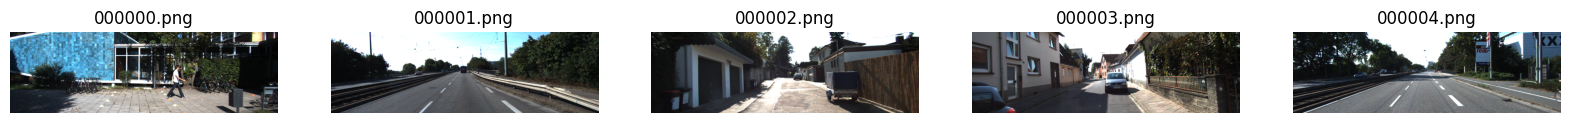

Analyzing image sizes:


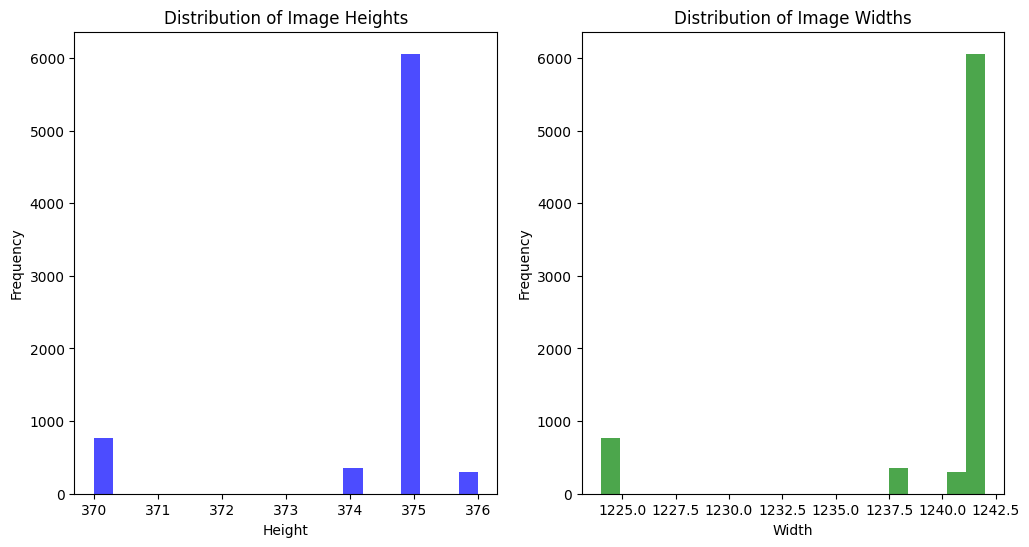

Counting classes in annotations:
Class counts: {'Pedestrian': 4487, 'Truck': 1094, 'Car': 28742, 'Cyclist': 1627, 'DontCare': 11295, 'Misc': 973, 'Van': 2914, 'Tram': 511, 'Person_sitting': 222}
Visualizing class distribution:


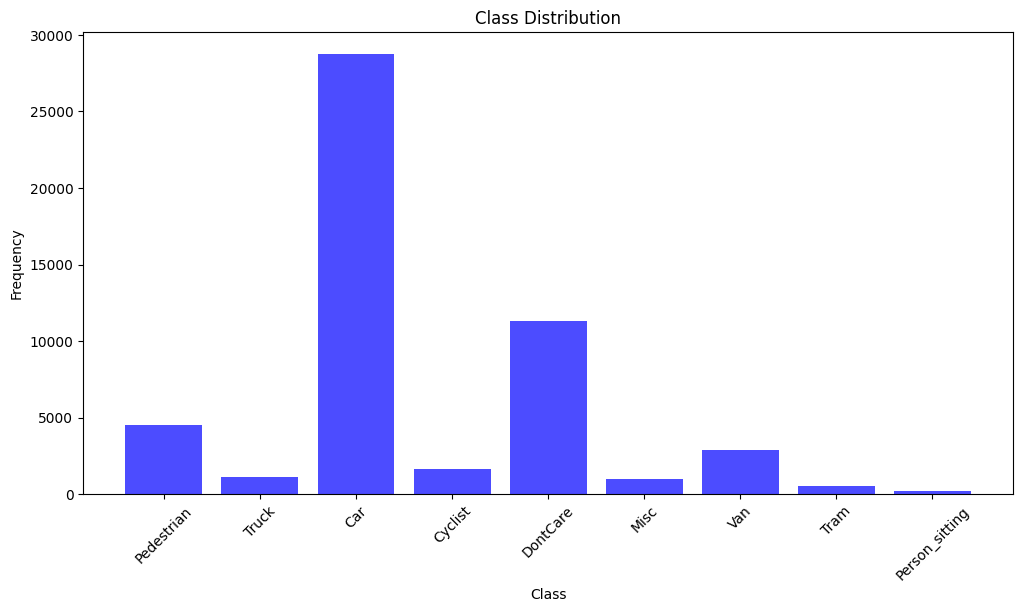

Displaying class statistics:
Total instances: 51865
Mean instances per class: 5762.777777777777
Standard deviation of instances per class: 8746.547150832057


In [8]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import numpy as np
from types import SimpleNamespace
from pathlib import Path

# Define the paths
meta = SimpleNamespace(base_dir = Path('/kaggle/input/kitti-dataset'))
meta.label_path = meta.base_dir / 'data_object_label_2' / 'training' / 'label_2'
meta.img_path = meta.base_dir / 'data_object_image_2' / 'training' / 'image_2'
meta.img_stereo_path = meta.base_dir / 'data_object_image_3' / 'training' / 'image_3'
meta.calib_path = meta.base_dir / 'data_object_calib' / 'training' / 'calib'
meta.ims = sorted(list(meta.img_path.glob('*')))
meta.labels = sorted(list(meta.label_path.glob('*')))
meta.stereo_ims = sorted(list(meta.img_stereo_path.glob('*')))
meta.label_colors = {
    'Car': (255,0,0),
    'Van': (255,255,0),
    'Truck': (255,255,255),
    'Pedestrian': (0,255,255),
    'Person_sitting': (0,255,255),
    'Cyclist': (0,128,255),
    'Tram': (128,0,0),
    'Misc': (0,255,255),
    'DontCare': (255,255,0)
}
meta.label_cols = [
    'label', 'truncated', 'occluded', 'alpha',
    'bbox_xmin', 'bbox_ymin', 'bbox_xmax',
    'bbox_ymax', 'dim_height', 'dim_width', 'dim_length',
    'loc_x', 'loc_y', 'loc_z', 'rotation_y', 'score'
]

meta.df = pd.DataFrame({
    'image': meta.ims,
    'stereo_image': meta.stereo_ims,
    'label': meta.labels
})

meta.im_width = 256
meta.im_height = 160

def get_label(p):
    data = pd.read_csv(
        p,
        sep=" ",
        names=meta.label_cols[:15],
        usecols=meta.label_cols[:15]
    )
    return data

# Visualize images to assess data quality
def visualize_images(image_paths, num_images=5):
    plt.figure(figsize=(20, 10))
    for i, img_path in enumerate(image_paths[:num_images]):
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"Image {img_path} is not readable.")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
    plt.show()

# Analyze image sizes and aspect ratios
def analyze_image_sizes(image_paths):
    image_shapes = [cv2.imread(str(img)).shape for img in image_paths if cv2.imread(str(img)) is not None]
    heights, widths = zip(*[(shape[0], shape[1]) for shape in image_shapes])

    # Plot distributions
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(heights, bins=20, color='blue', alpha=0.7)
    plt.title('Distribution of Image Heights')
    plt.xlabel('Height')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(widths, bins=20, color='green', alpha=0.7)
    plt.title('Distribution of Image Widths')
    plt.xlabel('Width')
    plt.ylabel('Frequency')
    plt.show()

# Count the number of instances per class
def count_classes_from_labels(label_paths):
    class_counts = {}
    for label_file in label_paths:
        data = get_label(label_file)
        for label in data['label']:
            class_counts[label] = class_counts.get(label, 0) + 1
    return class_counts

# Visualize the class distribution
def visualize_class_distribution(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(12, 6))
    plt.bar(classes, counts, color='blue', alpha=0.7)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Display statistics such as mean and standard deviation for each class
def display_class_statistics(class_counts):
    total_instances = sum(class_counts.values())
    mean_instances = np.mean(list(class_counts.values()))
    std_instances = np.std(list(class_counts.values()))

    print(f"Total instances: {total_instances}")
    print(f"Mean instances per class: {mean_instances}")
    print(f"Standard deviation of instances per class: {std_instances}")

# Data Quality Assessment
print("Visualizing images:")
visualize_images(meta.ims)

print("Analyzing image sizes:")
analyze_image_sizes(meta.ims)

# Class Analysis
print("Counting classes in annotations:")
class_counts = count_classes_from_labels(meta.labels)
print("Class counts:", class_counts)

# Visualize class distribution
print("Visualizing class distribution:")
visualize_class_distribution(class_counts)

# Display class statistics
print("Displaying class statistics:")
display_class_statistics(class_counts)


In [ ]:
#!ls -ltr /kaggle/input/data_object_label_2/training/label_2

## Exploratory Data Analysis (EDA)

### 1. Elimination of Variables

In [9]:
import pandas as pd
from pathlib import Path
from types import SimpleNamespace
import numpy as np

# Define paths
meta = SimpleNamespace(base_dir = Path('/kaggle/input/kitti-dataset'))
meta.label_path = meta.base_dir / 'data_object_label_2' / 'training' / 'label_2'
meta.label_cols = [
    'label', 'truncated', 'occluded', 'alpha',
    'bbox_xmin', 'bbox_ymin', 'bbox_xmax',
    'bbox_ymax', 'dim_height', 'dim_width', 'dim_length',
    'loc_x', 'loc_y', 'loc_z', 'rotation_y', 'score'
]
columns_to_keep = ['label', 'bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']

# Function to eliminate unnecessary variables
def eliminate_variables(label_file):
    data = pd.read_csv(
        label_file,
        sep=" ",
        names=meta.label_cols[:15],
        usecols=meta.label_cols[:15]
    )
    return data[columns_to_keep]

# Process the entire dataset
def process_dataset(label_path):
    all_data = []
    for label_file in label_path.glob('*.txt'):
        filtered_data = eliminate_variables(label_file)
        all_data.append(filtered_data)
    return pd.concat(all_data, ignore_index=True)

# Example usage
processed_data = process_dataset(meta.label_path)
print(processed_data.head())


  label  bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax
0   Car     572.30     185.01     621.87     225.02
1   Car     506.01     182.79     554.75     215.37
2   Car     354.98     183.52     401.03     207.84
3   Car       0.00     185.66     124.97     275.12
4   Van     597.32     165.04     621.59     197.95


### 2. Transformation into Categorical Variables

In [10]:
# Define mapping for labels to categorical values
label_mapping = {
    'Car': 0, 'Van': 1, 'Truck': 2, 'Pedestrian': 3, 
    'Person_sitting': 4, 'Cyclist': 5, 'Tram': 6, 'Misc': 7, 'DontCare': 8
}

# Function to transform labels into categorical variables
def transform_to_categorical(data):
    data['label'] = data['label'].map(label_mapping)
    return data

# Example usage
transformed_data = transform_to_categorical(processed_data)
print(transformed_data.head())


   label  bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax
0      0     572.30     185.01     621.87     225.02
1      0     506.01     182.79     554.75     215.37
2      0     354.98     183.52     401.03     207.84
3      0       0.00     185.66     124.97     275.12
4      1     597.32     165.04     621.59     197.95


### 3.Identification of Missing Values

In [11]:
# Function to identify missing values
def identify_missing_values(data):
    missing_values = data.isnull().sum()
    return missing_values

# Example usage
missing_values = identify_missing_values(transformed_data)
print(missing_values)


label        0
bbox_xmin    0
bbox_ymin    0
bbox_xmax    0
bbox_ymax    0
dtype: int64


### 4 Univariate Analysis


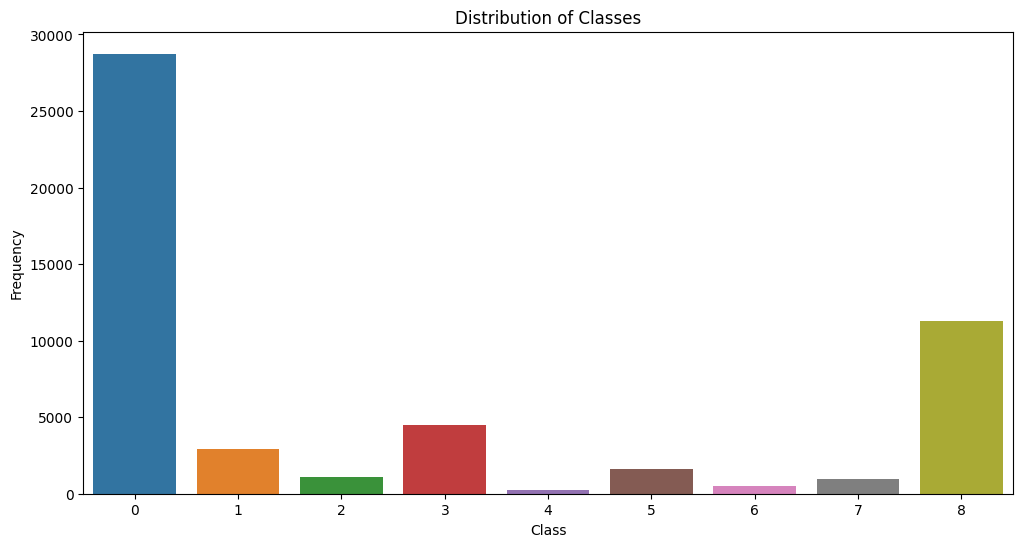

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to perform univariate analysis
def univariate_analysis(data):
    plt.figure(figsize=(12, 6))
    sns.countplot(x='label', data=data)
    plt.title('Distribution of Classes')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()

# Example usage
univariate_analysis(transformed_data)


### 5 Treatment of Missing Values

In [13]:
# Function to treat missing values
def treat_missing_values(data):
    # Example: Fill missing values with the mean of the column
    data = data.fillna(data.mean())
    return data

# Example usage
treated_data = treat_missing_values(transformed_data)
print(treated_data.isnull().sum())  # Check if missing values are treated


label        0
bbox_xmin    0
bbox_ymin    0
bbox_xmax    0
bbox_ymax    0
dtype: int64


### 6 Splitting of Original Dataset

In [14]:
from sklearn.model_selection import train_test_split

# Function to split the dataset
def split_dataset(data, test_size=0.2, val_size=0.1):
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=val_size/(1-test_size), random_state=42)
    return train_data, val_data, test_data

# Example usage
train_data, val_data, test_data = split_dataset(treated_data)
print("Train Data:", train_data.shape)
print("Validation Data:", val_data.shape)
print("Test Data:", test_data.shape)


Train Data: (36305, 5)
Validation Data: (5187, 5)
Test Data: (10373, 5)


# Exploratory Data Analysis (Bivariate Analysis)

### Chi-square Test

#### 1. Prepare the Dataset for the Chi-square Test

In [15]:
# Create a new column 'position' based on bbox_xmin
def create_position_column(data):
    data['position'] = data['bbox_xmin'].apply(lambda x: 'left' if x < data['bbox_xmin'].median() else 'right')
    return data

# Example usage
transformed_data = create_position_column(transformed_data)
print(transformed_data.head())


   label  bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax position
0      0     572.30     185.01     621.87     225.02    right
1      0     506.01     182.79     554.75     215.37     left
2      0     354.98     183.52     401.03     207.84     left
3      0       0.00     185.66     124.97     275.12     left
4      1     597.32     165.04     621.59     197.95    right


In [16]:
import pandas as pd

# Function to prepare the dataset for the Chi-square test
def prepare_chi_square_data(data, column):
    # Creating a contingency table
    contingency_table = pd.crosstab(data['label'], data[column])
    return contingency_table

# Example usage
contingency_table = prepare_chi_square_data(transformed_data, 'position')
print(contingency_table)


position   left  right
label                 
0         15653  13089
1          1455   1459
2           384    710
3          1873   2614
4            93    129
5           575   1052
6           244    267
7           668    305
8          4987   6308


#### Perform the Chi-square Test

In [17]:
from scipy.stats import chi2_contingency

# Function to perform the Chi-square test
def chi_square_test(contingency_table):
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p, dof, expected

# Example usage
chi2, p, dof, expected = chi_square_test(contingency_table)
print(f"Chi2: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)


Chi2: 884.8903162230265
P-value: 1.0253790132342183e-185
Degrees of Freedom: 8
Expected Frequencies:
[[14370.72291526 14371.27708474]
 [ 1456.97190784  1457.02809216]
 [  546.98945339   547.01054661]
 [ 2243.45674347  2243.54325653]
 [  110.99785983   111.00214017]
 [  813.48431505   813.51568495]
 [  255.49507375   255.50492625]
 [  486.49061988   486.50938012]
 [ 5647.39111154  5647.60888846]]


#### Interpret the Results

In [18]:
# Function to interpret the results of the Chi-square test
def interpret_chi_square(p, alpha=0.05):
    if p < alpha:
        print(f"Since p-value {p} < alpha {alpha}, we reject the null hypothesis.")
        print("There is a significant association between the variables.")
    else:
        print(f"Since p-value {p} >= alpha {alpha}, we fail to reject the null hypothesis.")
        print("There is no significant association between the variables.")

# Example usage
interpret_chi_square(p)


Since p-value 1.0253790132342183e-185 < alpha 0.05, we reject the null hypothesis.
There is a significant association between the variables.


## Full Integration

1. Create a New Categorical Column for Testing



In [19]:
# Create a new column 'position' based on bbox_xmin
def create_position_column(data):
    data['position'] = data['bbox_xmin'].apply(lambda x: 'left' if x < data['bbox_xmin'].median() else 'right')
    return data

# Example usage
transformed_data = create_position_column(transformed_data)
print(transformed_data.head())


   label  bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax position
0      0     572.30     185.01     621.87     225.02    right
1      0     506.01     182.79     554.75     215.37     left
2      0     354.98     183.52     401.03     207.84     left
3      0       0.00     185.66     124.97     275.12     left
4      1     597.32     165.04     621.59     197.95    right


#### Prepare the Dataset for the Chi-square Test

In [20]:
import pandas as pd

# Assuming transformed_data is already created from previous steps
# Function to prepare the dataset for the Chi-square test
def prepare_chi_square_data(data, column):
    # Creating a contingency table
    contingency_table = pd.crosstab(data['label'], data[column])
    return contingency_table

# Example usage
contingency_table = prepare_chi_square_data(transformed_data, 'position')
print(contingency_table)


position   left  right
label                 
0         15653  13089
1          1455   1459
2           384    710
3          1873   2614
4            93    129
5           575   1052
6           244    267
7           668    305
8          4987   6308


#### Perform the Chi-square Test

In [21]:
from scipy.stats import chi2_contingency

# Function to perform the Chi-square test
def chi_square_test(contingency_table):
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p, dof, expected

# Example usage
chi2, p, dof, expected = chi_square_test(contingency_table)
print(f"Chi2: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)


Chi2: 884.8903162230265
P-value: 1.0253790132342183e-185
Degrees of Freedom: 8
Expected Frequencies:
[[14370.72291526 14371.27708474]
 [ 1456.97190784  1457.02809216]
 [  546.98945339   547.01054661]
 [ 2243.45674347  2243.54325653]
 [  110.99785983   111.00214017]
 [  813.48431505   813.51568495]
 [  255.49507375   255.50492625]
 [  486.49061988   486.50938012]
 [ 5647.39111154  5647.60888846]]


#### Interpret the Results

In [22]:
# Function to interpret the results of the Chi-square test
def interpret_chi_square(p, alpha=0.05):
    if p < alpha:
        print(f"Since p-value {p} < alpha {alpha}, we reject the null hypothesis.")
        print("There is a significant association between the variables.")
    else:
        print(f"Since p-value {p} >= alpha {alpha}, we fail to reject the null hypothesis.")
        print("There is no significant association between the variables.")

# Example usage
interpret_chi_square(p)


Since p-value 1.0253790132342183e-185 < alpha 0.05, we reject the null hypothesis.
There is a significant association between the variables.


## Correlation Analysis

#### 1. Calculate Correlation Matrix for numerical variables

In [23]:
# Calculate the correlation matrix for numerical variables
correlation_matrix = transformed_data[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].corr()
print(correlation_matrix)


           bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax
bbox_xmin   1.000000  -0.257362   0.946288  -0.206396
bbox_ymin  -0.257362   1.000000  -0.280662   0.077147
bbox_xmax   0.946288  -0.280662   1.000000   0.024295
bbox_ymax  -0.206396   0.077147   0.024295   1.000000


### 2.Visualize Correlation Matrix

In [24]:
# Calculate the correlation matrix for numerical variables
correlation_matrix = transformed_data[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].corr()
print(correlation_matrix)


           bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax
bbox_xmin   1.000000  -0.257362   0.946288  -0.206396
bbox_ymin  -0.257362   1.000000  -0.280662   0.077147
bbox_xmax   0.946288  -0.280662   1.000000   0.024295
bbox_ymax  -0.206396   0.077147   0.024295   1.000000


## T-tests

### 1. Perform T-tests for All Pairs of Classes

In [25]:
from scipy.stats import ttest_ind
import itertools

# Function to perform T-test for all pairs of classes
def perform_all_t_tests(data, column):
    results = []
    unique_classes = data['label'].unique()
    class_pairs = list(itertools.combinations(unique_classes, 2))
    for label1, label2 in class_pairs:
        group1 = data[data['label'] == label1][column]
        group2 = data[data['label'] == label2][column]
        t_stat, p_val = ttest_ind(group1, group2)
        results.append((label1, label2, t_stat, p_val))
    return results

# Example usage
t_test_results = perform_all_t_tests(transformed_data, 'bbox_xmin')
for result in t_test_results:
    print(f"Labels: {result[0]} vs {result[1]}, T-statistic: {result[2]}, P-value: {result[3]}")

NameError: name 'c' is not defined

### ANOVA (Analysis of Variance)

### 1. Perform ANOVA for All Classes

In [26]:
from scipy.stats import f_oneway

# Function to perform ANOVA
def perform_anova(data, column):
    unique_classes = data['label'].unique()
    groups = [data[data['label'] == label][column] for label in unique_classes]
    f_stat, p_val = f_oneway(*groups)
    return f_stat, p_val

# Example usage
f_stat, p_val = perform_anova(transformed_data, 'bbox_xmin')
print(f"F-statistic: {f_stat}, P-value: {p_val}")


F-statistic: 190.4832940678666, P-value: 4.97905e-319


## Scatter Plots

#### 1. Create Scatter Plots for All Pairs of Numerical Variables

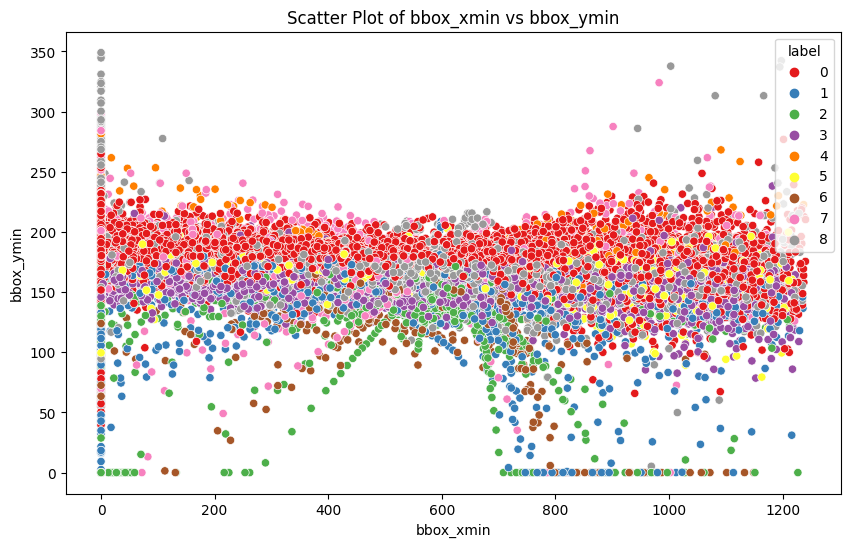

In [27]:
# Function to create scatter plot
def plot_scatter(data, x_col, y_col):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x_col, y=y_col, hue='label', data=data, palette='Set1')
    plt.title(f'Scatter Plot of {x_col} vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

# Example usage
plot_scatter(transformed_data, 'bbox_xmin', 'bbox_ymin')


### Box Plots

#### 1.Create Box Plots for All Numerical Variables

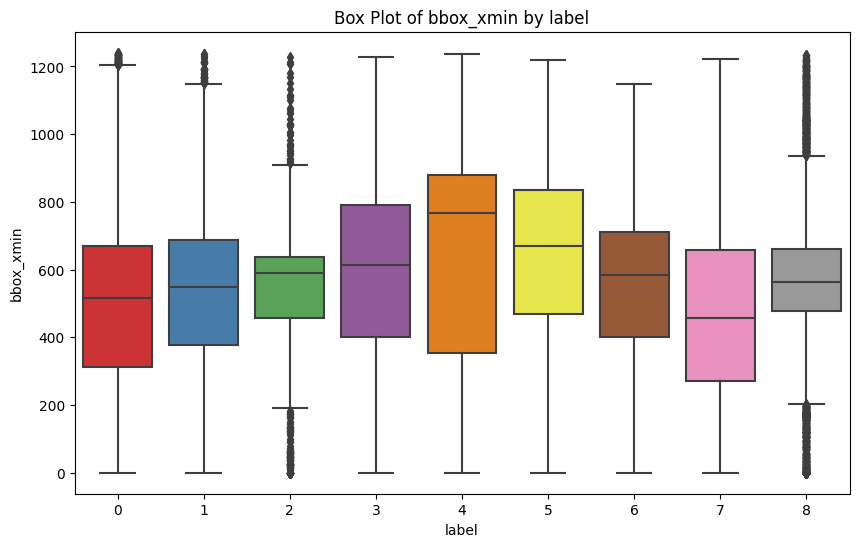

In [28]:
# Function to create box plot
def plot_box(data, x_col, y_col):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x_col, y=y_col, data=data, palette='Set1')
    plt.title(f'Box Plot of {y_col} by {x_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

# Example usage
plot_box(transformed_data, 'label', 'bbox_xmin')


### Full Example

#### 1.Correlation Analysis

           bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax
bbox_xmin   1.000000  -0.257362   0.946288  -0.206396
bbox_ymin  -0.257362   1.000000  -0.280662   0.077147
bbox_xmax   0.946288  -0.280662   1.000000   0.024295
bbox_ymax  -0.206396   0.077147   0.024295   1.000000


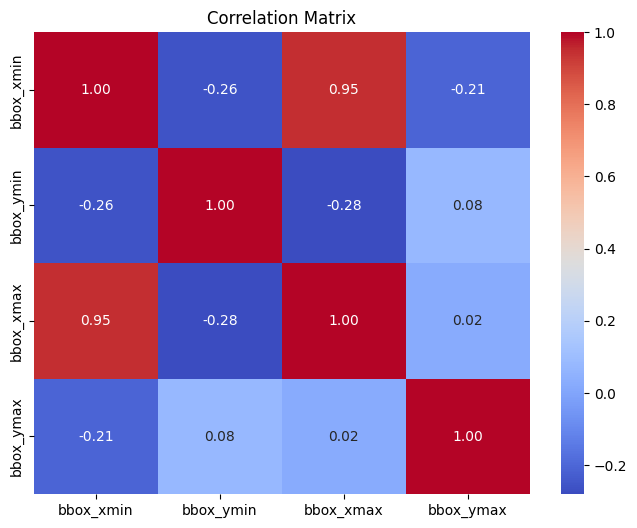

In [29]:
# Calculate the correlation matrix for numerical variables
correlation_matrix = transformed_data[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].corr()
print(correlation_matrix)

# Function to visualize the correlation matrix
def plot_correlation_matrix(correlation_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

# Example usage
plot_correlation_matrix(correlation_matrix)


#### 2. T-tests for All Pairs of Classes

In [30]:
from scipy.stats import ttest_ind
import itertools

# Function to perform T-test for all pairs of classes
def perform_all_t_tests(data, column):
    results = []
    unique_classes = data['label'].unique()
    class_pairs = list(itertools.combinations(unique_classes, 2))
    for label1, label2 in class_pairs:
        group1 = data[data['label'] == label1][column]
        group2 = data[data['label'] == label2][column]
        t_stat, p_val = ttest_ind(group1, group2)
        results.append((label1, label2, t_stat, p_val))
    return results

# Example usage
t_test_results = perform_all_t_tests(transformed_data, 'bbox_xmin')
for result in t_test_results:
    print(f"Labels: {result[0]} vs {result[1]}, T-statistic: {result[2]}, P-value: {result[3]}")


Labels: 0 vs 1, T-statistic: -8.03112925458136, P-value: 9.990195989713702e-16
Labels: 0 vs 8, T-statistic: -25.01710359501773, P-value: 4.517626164679011e-137
Labels: 0 vs 7, T-statistic: 1.8472704993492328, P-value: 0.06471788080072037
Labels: 0 vs 5, T-statistic: -21.645663144073488, P-value: 4.0257588946466487e-103
Labels: 0 vs 3, T-statistic: -25.81138066350597, P-value: 1.8014357520169427e-145
Labels: 0 vs 2, T-statistic: -5.235168187563108, P-value: 1.659499578466869e-07
Labels: 0 vs 6, T-statistic: -3.0997261202128614, P-value: 0.0019388348770360956
Labels: 0 vs 4, T-statistic: -7.744287187477933, P-value: 9.924829690256801e-15
Labels: 1 vs 8, T-statistic: -6.020438343769161, P-value: 1.7823083965291019e-09
Labels: 1 vs 7, T-statistic: 5.602665393039123, P-value: 2.2571609899988315e-08
Labels: 1 vs 5, T-statistic: -12.46543230357431, P-value: 4.3014265794894503e-35
Labels: 1 vs 3, T-statistic: -10.581183467491366, P-value: 5.58276261650788e-26
Labels: 1 vs 2, T-statistic: -0.10

#### 3. ANOVA for All Classes

In [31]:
from scipy.stats import f_oneway

# Function to perform ANOVA
def perform_anova(data, column):
    unique_classes = data['label'].unique()
    groups = [data[data['label'] == label][column] for label in unique_classes]
    f_stat, p_val = f_oneway(*groups)
    return f_stat, p_val

# Example usage
f_stat, p_val = perform_anova(transformed_data, 'bbox_xmin')
print(f"F-statistic: {f_stat}, P-value: {p_val}")


F-statistic: 190.4832940678666, P-value: 4.97905e-319


#### 4. Scatter Plots for Numerical Variables

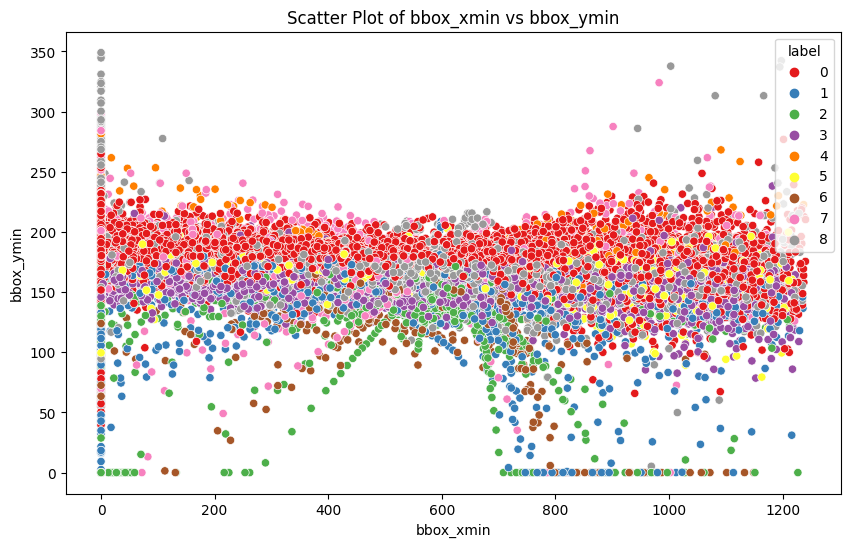

In [32]:
# Function to create scatter plot
def plot_scatter(data, x_col, y_col):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x_col, y=y_col, hue='label', data=data, palette='Set1')
    plt.title(f'Scatter Plot of {x_col} vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

# Example usage
plot_scatter(transformed_data, 'bbox_xmin', 'bbox_ymin')


#### 5. Box Plots for Numerical Variables

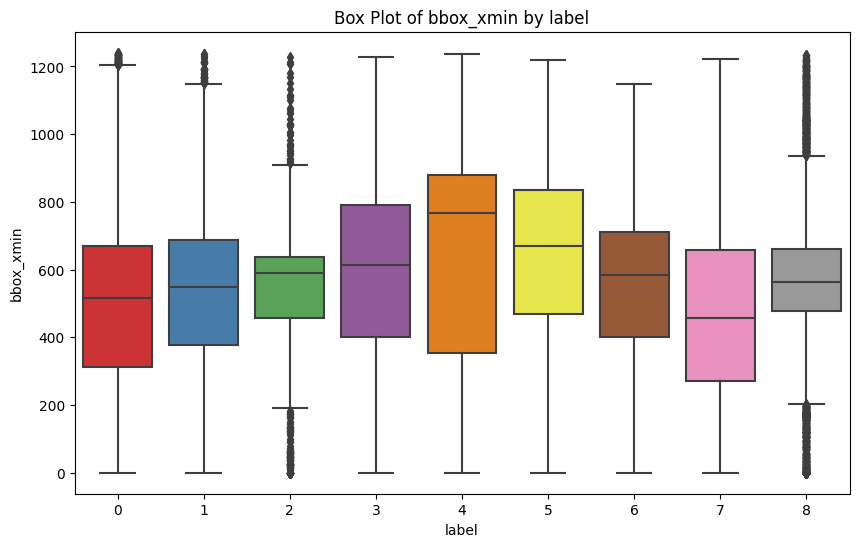

In [33]:
# Function to create box plot
def plot_box(data, x_col, y_col):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x_col, y=y_col, data=data, palette='Set1')
    plt.title(f'Box Plot of {y_col} by {x_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

# Example usage
plot_box(transformed_data, 'label', 'bbox_xmin')


## **Data Visualization**

### **1. Class Distribution**

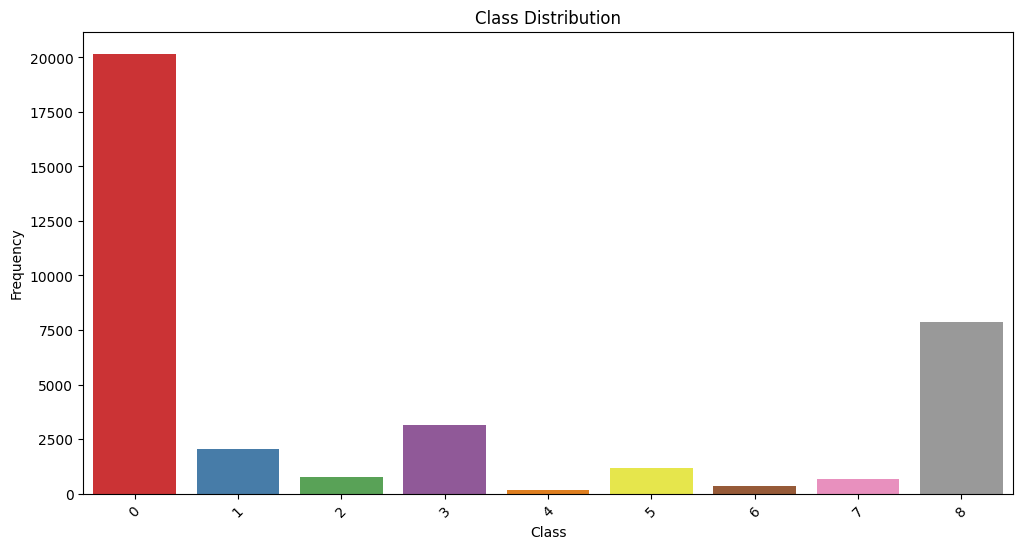

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to visualize class distribution
def visualize_class_distribution(data):
    plt.figure(figsize=(12, 6))
    sns.countplot(x='label', data=data, palette='Set1')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

    
    
# Adding the image_path to the train_data for visualization purposes
#train_data['image_path'] = train_data['image'].apply(lambda x: str(meta.img_path / x))

# Example usage
visualize_class_distribution(train_data)

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to visualize class distribution
def visualize_class_distribution(data):
    plt.figure(figsize=(12, 6))
    sns.countplot(x='label', data=data, palette='Set1')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Example usage
visualize_class_distribution(train_data)

SyntaxError: invalid syntax (1305497275.py, line 1)

### 2. Bounding Box Size Distribution

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


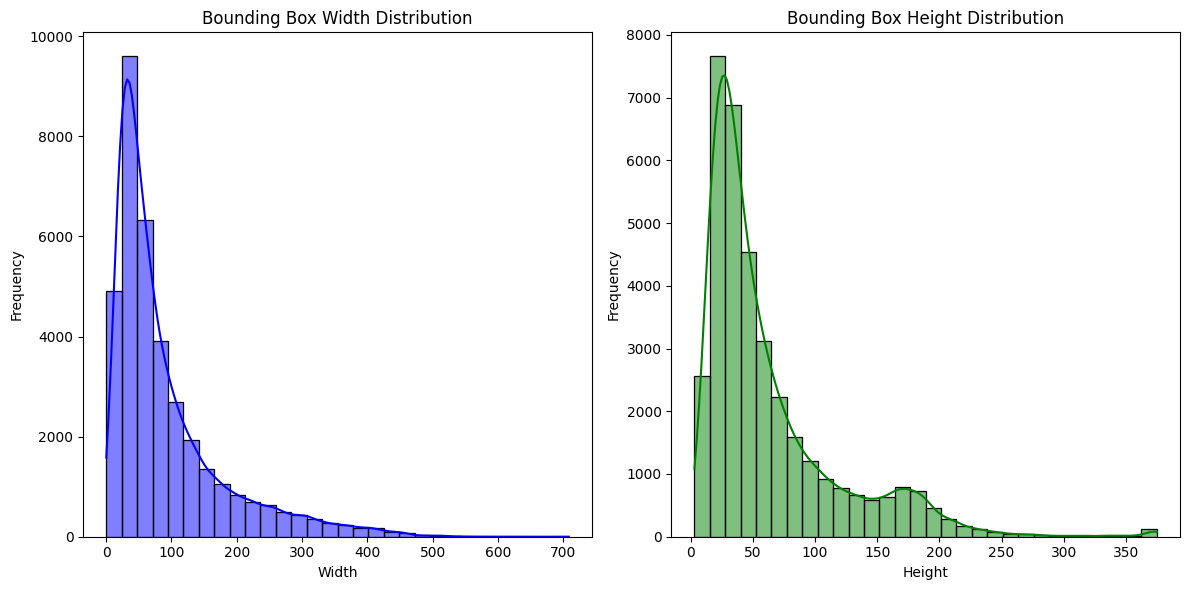

In [36]:
# Calculate bounding box sizes
train_data['bbox_width'] = train_data['bbox_xmax'] - train_data['bbox_xmin']
train_data['bbox_height'] = train_data['bbox_ymax'] - train_data['bbox_ymin']

# Function to visualize bounding box size distribution
def visualize_bbox_size_distribution(data):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(data['bbox_width'], bins=30, kde=True, color='blue')
    plt.title('Bounding Box Width Distribution')
    plt.xlabel('Width')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(data['bbox_height'], bins=30, kde=True, color='green')
    plt.title('Bounding Box Height Distribution')
    plt.xlabel('Height')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Example usage
visualize_bbox_size_distribution(train_data)


### 3. Bounding Box Position Distribution

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


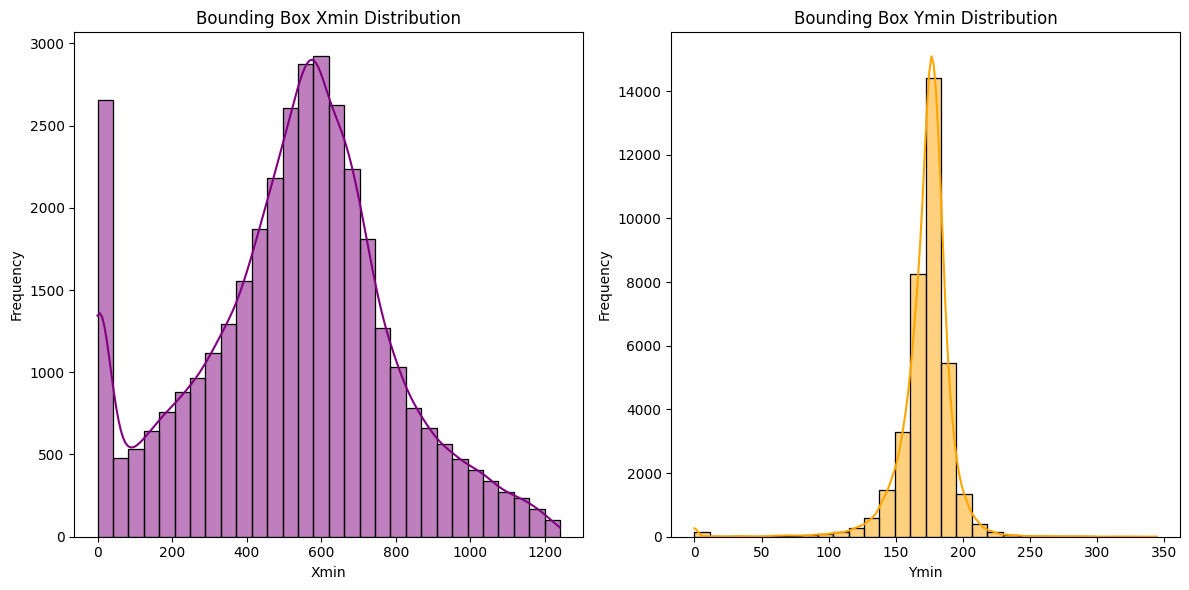

In [37]:
# Function to visualize bounding box position distribution
def visualize_bbox_position_distribution(data):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(data['bbox_xmin'], bins=30, kde=True, color='purple')
    plt.title('Bounding Box Xmin Distribution')
    plt.xlabel('Xmin')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(data['bbox_ymin'], bins=30, kde=True, color='orange')
    plt.title('Bounding Box Ymin Distribution')
    plt.xlabel('Ymin')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Example usage
visualize_bbox_position_distribution(train_data)


### 4. Correlation Heatmap

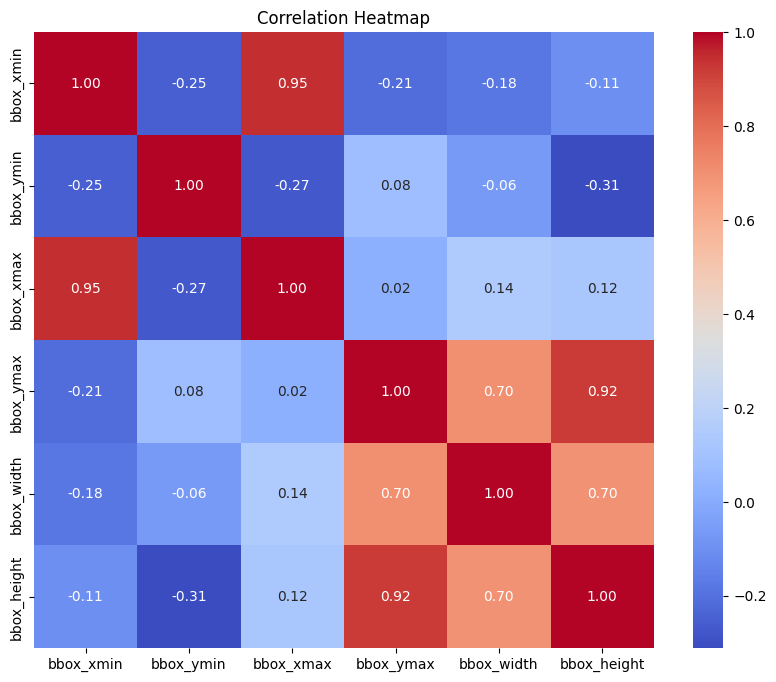

In [38]:
# Function to plot correlation heatmap
def plot_correlation_heatmap(data):
    correlation_matrix = data[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax', 'bbox_width', 'bbox_height']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()

# Example usage
plot_correlation_heatmap(train_data)


### 5. Scatter Plots for Bounding Box Positions

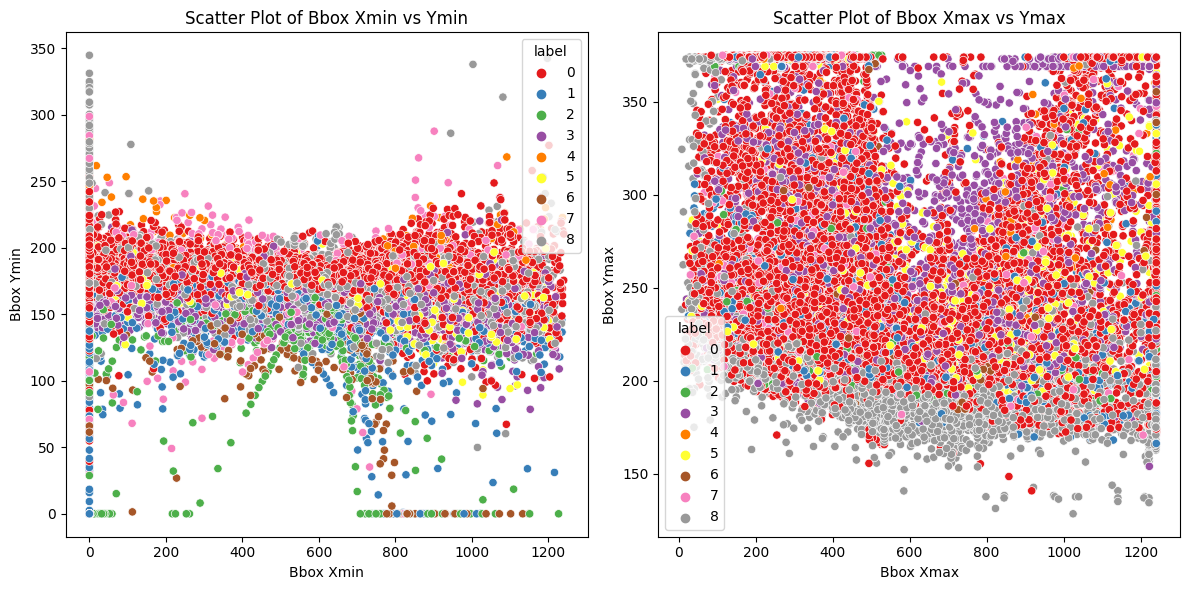

In [39]:
# Function to plot scatter plots
def plot_scatter_plots(data):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x='bbox_xmin', y='bbox_ymin', hue='label', data=data, palette='Set1')
    plt.title('Scatter Plot of Bbox Xmin vs Ymin')
    plt.xlabel('Bbox Xmin')
    plt.ylabel('Bbox Ymin')

    plt.subplot(1, 2, 2)
    sns.scatterplot(x='bbox_xmax', y='bbox_ymax', hue='label', data=data, palette='Set1')
    plt.title('Scatter Plot of Bbox Xmax vs Ymax')
    plt.xlabel('Bbox Xmax')
    plt.ylabel('Bbox Ymax')

    plt.tight_layout()
    plt.show()

# Example usage
plot_scatter_plots(train_data)


### 6. Box Plots for Bounding Box Sizes by Class

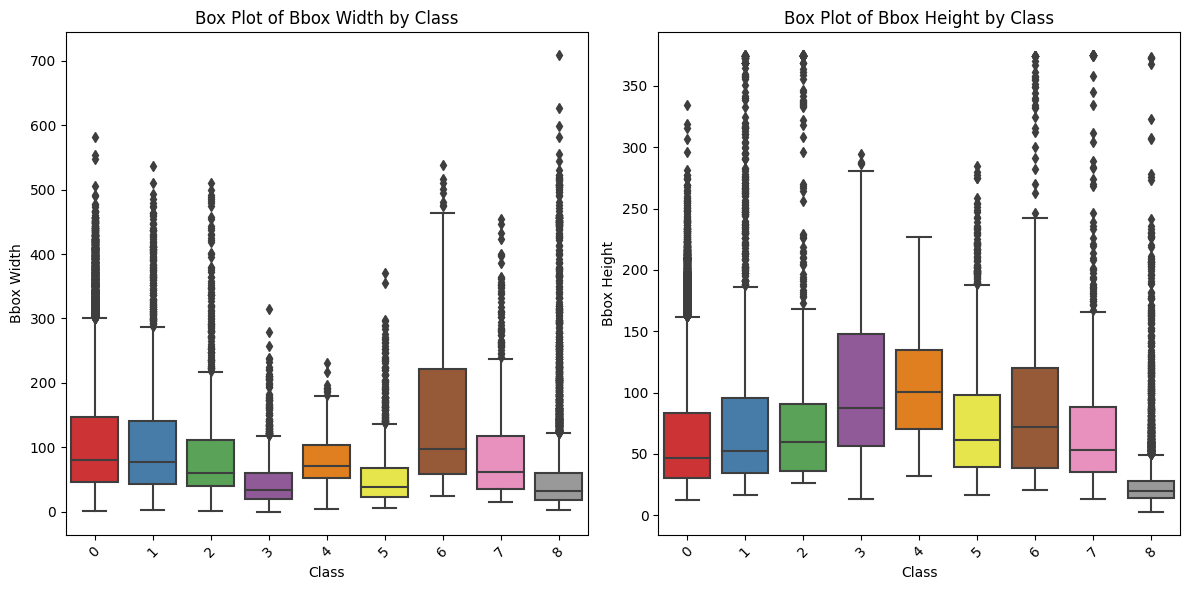

In [40]:
# Function to plot box plots
def plot_box_plots(data):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='label', y='bbox_width', data=data, palette='Set1')
    plt.title('Box Plot of Bbox Width by Class')
    plt.xlabel('Class')
    plt.ylabel('Bbox Width')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.boxplot(x='label', y='bbox_height', data=data, palette='Set1')
    plt.title('Box Plot of Bbox Height by Class')
    plt.xlabel('Class')
    plt.ylabel('Bbox Height')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Example usage
plot_box_plots(train_data)


### 7.Images with Bounding Boxes

In [41]:
import pandas as pd
from pathlib import Path
from types import SimpleNamespace
import numpy as np

# Define paths
meta = SimpleNamespace(base_dir = Path('/kaggle/input/kitti-dataset'))
meta.label_path = meta.base_dir / 'data_object_label_2' / 'training' / 'label_2'
meta.label_cols = [
    'label', 'truncated', 'occluded', 'alpha',
    'bbox_xmin', 'bbox_ymin', 'bbox_xmax',
    'bbox_ymax', 'dim_height', 'dim_width', 'dim_length',
    'loc_x', 'loc_y', 'loc_z', 'rotation_y', 'score'
]
columns_to_keep = ['label', 'bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']

# Function to eliminate unnecessary variables
def eliminate_variables(label_file):
    data = pd.read_csv(
        label_file,
        sep=" ",
        names=meta.label_cols[:15],
        usecols=meta.label_cols[:15]
    )
    return data[columns_to_keep]

# Process the entire dataset
def process_dataset(label_path):
    all_data = []
    for label_file in label_path.glob('*.txt'):
        filtered_data = eliminate_variables(label_file)
        all_data.append(filtered_data)
    return pd.concat(all_data, ignore_index=True)

# Example usage
processed_data = process_dataset(meta.label_path)
print(processed_data.head())

  label  bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax
0   Car     572.30     185.01     621.87     225.02
1   Car     506.01     182.79     554.75     215.37
2   Car     354.98     183.52     401.03     207.84
3   Car       0.00     185.66     124.97     275.12
4   Van     597.32     165.04     621.59     197.95


In [42]:
# Define mapping for labels to categorical values
label_mapping = {
    'Car': 0, 'Van': 1, 'Truck': 2, 'Pedestrian': 3, 
    'Person_sitting': 4, 'Cyclist': 5, 'Tram': 6, 'Misc': 7, 'DontCare': 8
}

# Function to transform labels into categorical variables
def transform_to_categorical(data):
    data['label'] = data['label'].map(label_mapping)
    return data

# Example usage
transformed_data = transform_to_categorical(processed_data)
print(transformed_data.head())

   label  bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax
0      0     572.30     185.01     621.87     225.02
1      0     506.01     182.79     554.75     215.37
2      0     354.98     183.52     401.03     207.84
3      0       0.00     185.66     124.97     275.12
4      1     597.32     165.04     621.59     197.95


In [43]:
# Function to treat missing values
def treat_missing_values(data):
    # Example: Fill missing values with the mean of the column
    data = data.fillna(data.mean())
    return data

# Example usage
treated_data = treat_missing_values(transformed_data)
print(treated_data.isnull().sum())

label        0
bbox_xmin    0
bbox_ymin    0
bbox_xmax    0
bbox_ymax    0
dtype: int64


In [44]:
from sklearn.model_selection import train_test_split

# Function to split the dataset
def split_dataset(data, test_size=0.2, val_size=0.1):
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=val_size/(1-test_size), random_state=42)
    return train_data, val_data, test_data

# Example usage
train_data, val_data, test_data = split_dataset(treated_data)
print("Train Data:", train_data.shape)
print("Validation Data:", val_data.shape)
print("Test Data:", test_data.shape)

Train Data: (36305, 5)
Validation Data: (5187, 5)
Test Data: (10373, 5)


In [45]:
print(transformed_data.head())

   label  bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax
0      0     572.30     185.01     621.87     225.02
1      0     506.01     182.79     554.75     215.37
2      0     354.98     183.52     401.03     207.84
3      0       0.00     185.66     124.97     275.12
4      1     597.32     165.04     621.59     197.95


### Adding the 'image' column if it is not exist

In [46]:
import pandas as pd
from pathlib import Path
from types import SimpleNamespace

# Define paths
meta = SimpleNamespace(base_dir = Path('/kaggle/input/kitti-dataset'))
meta.label_path = meta.base_dir / 'data_object_label_2' / 'training' / 'label_2'
meta.img_path = meta.base_dir / 'data_object_image_2' / 'training' / 'image_2'
meta.label_cols = [
    'label', 'truncated', 'occluded', 'alpha',
    'bbox_xmin', 'bbox_ymin', 'bbox_xmax',
    'bbox_ymax', 'dim_height', 'dim_width', 'dim_length',
    'loc_x', 'loc_y', 'loc_z', 'rotation_y'
]

# Load dataset function
def load_dataset(label_path, label_cols):
    all_data = []
    for label_file in label_path.glob('*.txt'):
        data = pd.read_csv(
            label_file,
            sep=" ",
            names=label_cols,
            usecols=label_cols
        )
        # Extract image filenames from label filenames
        data['image'] = label_file.stem + '.png'
        all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

# Eliminate unnecessary variables
def eliminate_variables(data):
    columns_to_keep = ['label', 'bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax', 'image']
    return data[columns_to_keep]

# Transform labels into categorical variables
def transform_to_categorical(data):
    label_mapping = {
        'Car': 0, 'Van': 1, 'Truck': 2, 'Pedestrian': 3, 
        'Person_sitting': 4, 'Cyclist': 5, 'Tram': 6, 'Misc': 7, 'DontCare': 8
    }
    data['label'] = data['label'].map(label_mapping)
    return data

# Identify and treat missing values
def treat_missing_values(data):
    # Treat only numerical columns for missing values
    numerical_cols = ['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']
    data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].mean())
    return data

# Split the dataset
from sklearn.model_selection import train_test_split

def split_dataset(data):
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.1/(0.9+0.1), random_state=42)
    return train_data, val_data, test_data

# Full data preparation pipeline
def prepare_data(label_path, label_cols):
    raw_data = load_dataset(label_path, label_cols)
    processed_data = eliminate_variables(raw_data)
    processed_data = transform_to_categorical(processed_data)
    processed_data = treat_missing_values(processed_data)
    train_data, val_data, test_data = split_dataset(processed_data)
    return train_data, val_data, test_data

# Execute data preparation
train_data, val_data, test_data = prepare_data(meta.label_path, meta.label_cols)

# Check the first few rows of train_data
print(train_data.head())


       label  bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax       image
24303      0     410.89     183.43     465.31     213.35  000095.png
19273      0     552.27     177.86     572.91     198.02  000235.png
1457       8     518.94     179.19     542.94     193.81  000650.png
49467      0     581.15     180.43     598.61     194.26  004644.png
18285      0     267.28     180.95     433.94     295.88  002841.png


/tmp/ipykernel_34/3067821188.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['label'].map(label_mapping)
/tmp/ipykernel_34/3067821188.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].mean())


### Visualization of object segmentation

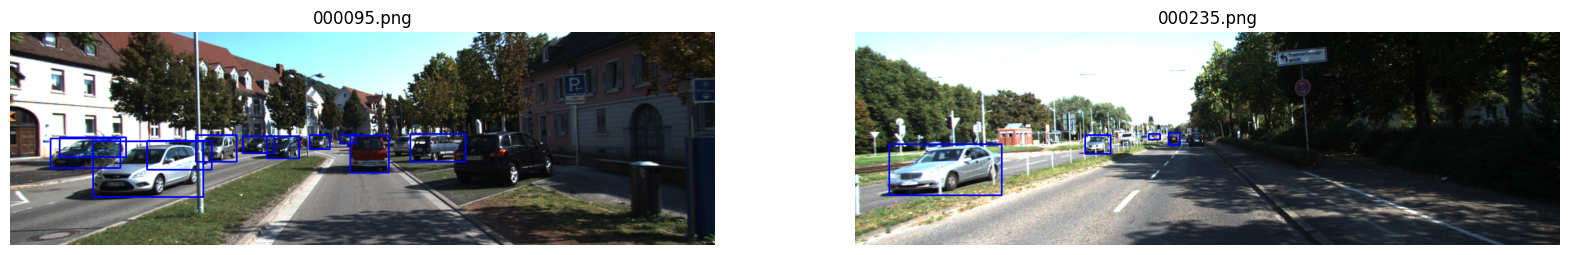

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os

# Function to draw bounding boxes on images
def draw_bounding_boxes(image_path, labels, color=(255, 0, 0)):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return None
    for _, row in labels.iterrows():
        cv2.rectangle(image, (int(row['bbox_xmin']), int(row['bbox_ymin'])), 
                      (int(row['bbox_xmax']), int(row['bbox_ymax'])), color, 2)
    return image

# Function to visualize example images with bounding boxes
def visualize_example_images(data, img_base_path, num_images=5):
    plt.figure(figsize=(20, 10))
    unique_images = data['image'].unique()
    for i, img_file in enumerate(unique_images[:num_images]):
        img_path = str(img_base_path / img_file)
        labels = data[data['image'] == img_file]
        image_with_boxes = draw_bounding_boxes(img_path, labels)
        if image_with_boxes is not None:
            plt.subplot(1, num_images, i+1)
            plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
            plt.title(os.path.basename(img_path))
            plt.axis('off')
    plt.show()

# Adding the image_path to the train_data for visualization purposes
train_data['image_path'] = train_data['image'].apply(lambda x: str(meta.img_path / x))

# Example usage
visualize_example_images(train_data, meta.img_path, num_images=2)


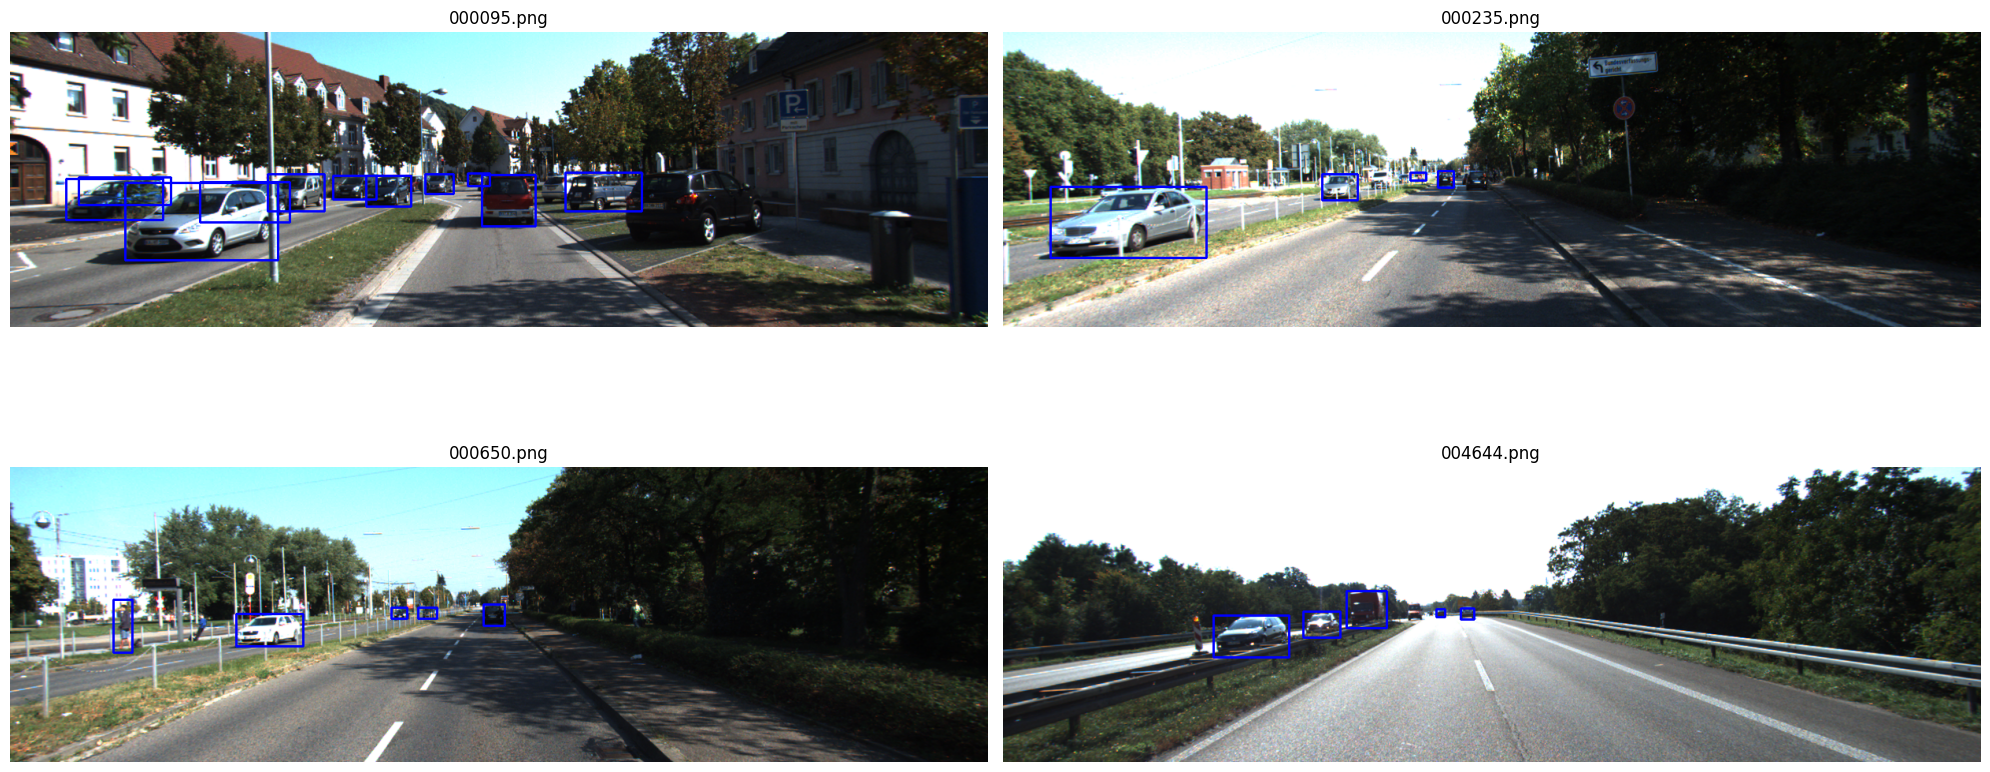

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os

# Function to draw bounding boxes on images
def draw_bounding_boxes(image_path, labels, color=(255, 0, 0)):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return None
    for _, row in labels.iterrows():
        cv2.rectangle(image, (int(row['bbox_xmin']), int(row['bbox_ymin'])), 
                      (int(row['bbox_xmax']), int(row['bbox_ymax'])), color, 2)
    return image

# Function to visualize example images with bounding boxes
def visualize_example_images(data, img_base_path, num_images=4):
    plt.figure(figsize=(20, 10))  # Set figure size to make images larger
    unique_images = data['image'].unique()
    for i, img_file in enumerate(unique_images[:num_images]):
        img_path = str(img_base_path / img_file)
        labels = data[data['image'] == img_file]
        image_with_boxes = draw_bounding_boxes(img_path, labels)
        if image_with_boxes is not None:
            plt.subplot(2, 2, i+1)  # Set up 2 rows and 2 columns
            plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
            plt.title(os.path.basename(img_path))
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Adding the image_path to the train_data for visualization purposes
train_data['image_path'] = train_data['image'].apply(lambda x: str(meta.img_path / x))

# Example usage
visualize_example_images(train_data, meta.img_path, num_images=4)


In [49]:
!pip install tqdm

In [50]:
!pip install Pillow

In [51]:
from tqdm import tqdm
import csv
from PIL import Image


all_classes = []

OUT_LABELS_DIR = "labels_with_dont_care"

KEY_DONT_CARE = "DontCare"

class_names = ['Car', 'Pedestrian', 'Van', 'Cyclist', 'Truck', 'Misc', 'Tram', 'Person_sitting', 'DontCare']

CLAZZ_NUMBERS = {
    name: idx for idx,name in enumerate(class_names)
}

def getSampleId(path):
    basename = os.path.basename(path)
    return os.path.splitext(basename)[0]

def resolveClazzNumberOrNone(clazz, use_dont_care):
#     if clazz == KEY_CYCLIST:
#         return CLAZZ_NUMBERS[KEY_CYCLIST]
#     #if clazz in (KEY_PEDESTRIAN, KEY_PERSON_SITTING):
#     if clazz == KEY_PEDESTRIAN:
#         return CLAZZ_NUMBERS[KEY_PEDESTRIAN]
#     #if clazz in (KEY_CAR, KEY_VAN):
#     if clazz == KEY_CAR:
#         return CLAZZ_NUMBERS[KEY_CAR]
#     if use_dont_care and clazz == KEY_DONT_CARE:
#         return CLAZZ_NUMBERS[KEY_DONT_CARE] # These should not be punished.
    if use_dont_care and clazz == KEY_DONT_CARE:
        return CLAZZ_NUMBERS[clazz]
    elif clazz != KEY_DONT_CARE:
        return CLAZZ_NUMBERS[clazz]
    return None

def convertToYoloBBox(bbox, size):
    # Yolo uses bounding bbox coordinates and size relative to the image size.
    # This is taken from https://pjreddie.com/media/files/voc_label.py .
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (bbox[0] + bbox[1]) / 2.0
    y = (bbox[2] + bbox[3]) / 2.0
    w = bbox[1] - bbox[0]
    h = bbox[3] - bbox[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

def readRealImageSize(img_path):
    # This loads the whole sample image and returns its size.
    return Image.open(img_path).size

def readFixedImageSize():
    # This is not exact for all images but most (and it should be faster).
    return (1242, 375)

def parseSample(lbl_path, img_path, use_dont_care):
    with open(lbl_path) as csv_file:
        reader = csv.DictReader(csv_file, fieldnames=["type", "truncated", "occluded", "alpha", "bbox2_left", "bbox2_top", "bbox2_right", "bbox2_bottom", "bbox3_height", "bbox3_width", "bbox3_length", "bbox3_x", "bbox3_y", "bbox3_z", "bbox3_yaw", "score"], delimiter=" ")
        yolo_labels = []
        for row in reader:
            all_classes.append(row['type'])
            clazz_number = resolveClazzNumberOrNone(row["type"], use_dont_care)
            if clazz_number is not None:
                size = readRealImageSize(img_path)
                #size = readFixedImageSize()
                # Image coordinate is in the top left corner.
                bbox = (
                        float(row["bbox2_left"]),
                        float(row["bbox2_right"]),
                        float(row["bbox2_top"]),
                        float(row["bbox2_bottom"])
                       )
                yolo_bbox = convertToYoloBBox(bbox, size)
                # Yolo expects the labels in the form:
                # <object-class> <x> <y> <width> <height>.
                yolo_label = (clazz_number,) + yolo_bbox
                yolo_labels.append(yolo_label)
    return yolo_labels


args = SimpleNamespace(
    label_dir = str(meta.label_path),
    image_2_dir = str(meta.img_path),
    training_samples = 1,
    use_dont_care = True
)

if not os.path.exists(OUT_LABELS_DIR):
    os.makedirs(OUT_LABELS_DIR)

print("Generating darknet labels...")
sample_img_pathes = []
for dir_path, sub_dirs, files in os.walk(args.label_dir):
    for file_name in tqdm(files):
        if file_name.endswith(".txt"):
            lbl_path = os.path.join(dir_path, file_name)
            sample_id = getSampleId(lbl_path)
            img_path = os.path.join(args.image_2_dir, "{}.png".format(sample_id))
            sample_img_pathes.append(img_path)
            yolo_labels = parseSample(lbl_path, img_path, args.use_dont_care)
            with open(os.path.join(OUT_LABELS_DIR, "{}.txt".format(sample_id)), "w") as yolo_label_file:
                for lbl in yolo_labels:
                    yolo_label_file.write("{} {} {} {} {}\n".format(*lbl))

Generating darknet labels...


100%|██████████| 7481/7481 [00:41<00:00, 182.33it/s]


In [52]:
import json

In [53]:
with open('classes_with_dont_care.json','w') as f:
    json.dump(CLAZZ_NUMBERS,f)

In [ ]:
!ls -ltr

In [ ]:
!pwd

In [ ]:
!du -h --max-depth=5

In [ ]:
#!ls -ltr /kaggle/working

In [ ]:
#!rm -rf /kaggle/working/*

In [54]:
CLAZZ_NUMBERS

{'Car': 0,
 'Pedestrian': 1,
 'Van': 2,
 'Cyclist': 3,
 'Truck': 4,
 'Misc': 5,
 'Tram': 6,
 'Person_sitting': 7,
 'DontCare': 8}

In [55]:
!ls -ltr /kaggle/working

total 236
drwxr-xr-x 2 root root 237568 Jun 16 20:25 labels_with_dont_care
-rw-r--r-- 1 root root    121 Jun 16 20:25 classes_with_dont_care.json


In [56]:
!pip install ultralytics -q

In [57]:
%env WANDB_DISABLED=True

env: WANDB_DISABLED=True


In [58]:
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import shutil
from PIL import Image

In [ ]:
!find / -name classes_with_dont_care.json

In [ ]:
!ls -ltr /kaggle/input/kitti-dataset/data_object_image_2/training

In [ ]:
!ls -ltr /kaggle/labels_with_dont_care

In [59]:
base_dir = Path('/kaggle/input/kitti-dataset')
img_path = base_dir / 'data_object_image_2' / 'training' / 'image_2'
label_path = Path('/kaggle/working/labels_with_dont_care')
with open('classes_with_dont_care.json','r') as f:
    classes = json.load(f)

classes

{'Car': 0,
 'Pedestrian': 1,
 'Van': 2,
 'Cyclist': 3,
 'Truck': 4,
 'Misc': 5,
 'Tram': 6,
 'Person_sitting': 7,
 'DontCare': 8}

In [60]:
ims = sorted(list(img_path.glob('*')))
labels = sorted(list(label_path.glob('*')))
pairs = list(zip(ims,labels))
pairs[:2]

[(PosixPath('/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000000.png'),
  PosixPath('/kaggle/working/labels_with_dont_care/000000.txt')),
 (PosixPath('/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000001.png'),
  PosixPath('/kaggle/working/labels_with_dont_care/000001.txt'))]

In [61]:
ims = sorted(list(img_path.glob('*')))
labels = sorted(list(label_path.glob('*')))
pairs = list(zip(ims,labels))
pairs[:2]

[(PosixPath('/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000000.png'),
  PosixPath('/kaggle/working/labels_with_dont_care/000000.txt')),
 (PosixPath('/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000001.png'),
  PosixPath('/kaggle/working/labels_with_dont_care/000001.txt'))]

In [ ]:
#print(len(test))

In [62]:
train, test = train_test_split(pairs,test_size=0.1,shuffle=True)
len(train), len(test)

(6732, 749)

In [ ]:
#print(len(train_path))

In [63]:
train_path = Path('train').resolve()
train_path.mkdir(exist_ok=True)
valid_path = Path('valid').resolve()
valid_path.mkdir(exist_ok=True)

In [64]:
for t_img, t_lb in tqdm(train):
    im_path = train_path / t_img.name
    lb_path = train_path / t_lb.name
    shutil.copy(t_img,im_path)
    shutil.copy(t_lb,lb_path)

  0%|          | 0/6732 [00:00<?, ?it/s]

In [65]:
for t_img, t_lb in tqdm(test):
    im_path = valid_path / t_img.name
    lb_path = valid_path / t_lb.name
    shutil.copy(t_img,im_path)
    shutil.copy(t_lb,lb_path)

  0%|          | 0/749 [00:00<?, ?it/s]

### Data preparation for Model as YAML file

In [66]:
yaml_file = 'names:\n'
yaml_file += '\n'.join(f'- {c}' for c in classes)
yaml_file += f'\nnc: {len(classes)}'
yaml_file += f'\ntrain: {str(train_path)}\nval: {str(valid_path)}'
with open('kitti.yaml','w') as f:
    f.write(yaml_file)

In [67]:
!cat kitti.yaml

names:
- Car
- Pedestrian
- Van
- Cyclist
- Truck
- Misc
- Tram
- Person_sitting
- DontCare
nc: 9
train: /kaggle/working/train
val: /kaggle/working/valid

In [ ]:
!pwd

In [ ]:
!ls -ltr 

## **Model**

In [68]:
import torch
torch.cuda.is_available()

True

In [69]:
model = YOLO('yolov8n.yaml')

## Training the Yolov8 Model from Stratch

In [ ]:
train_results = model.train(
    data='kitti.yaml', # Path to the dataset configuration file,
    epochs=50, # Increased epochs
    patience=0, # No early stopping
    batch=16,# Batch size
    imgsz=640,  # Image size
    mixup=0.1,# Mixup augmentation factor
    project='Yarra-yolov8n-kitti', # Project name
    name='object_june16',# Naming the experiment
    device=0)# Use GPU if available, specified as a string

Ultralytics YOLOv8.2.33 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=kitti.yaml, epochs=50, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=Yarra-yolov8n-kitti, name=object_june16, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

100%|██████████| 755k/755k [00:00<00:00, 15.2MB/s]
2024-06-16 20:28:10,576	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-16 20:28:11,527	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 76.5MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/train... 6732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6732/6732 [00:37<00:00, 179.35it/s]


train: New cache created: /kaggle/working/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/valid... 749 images, 0 backgrounds, 0 corrupt: 100%|██████████| 749/749 [00:04<00:00, 171.35it/s]

val: New cache created: /kaggle/working/valid.cache


Plotting labels to Yarra-yolov8n-kitti/object_june16/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to Yarra-yolov8n-kitti/object_june16
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.49G      3.671      3.939      3.385        180        640: 100%|██████████| 421/421 [01:37<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  58%|█████▊    | 14/24 [00:04<00:02,  4.64it/s]

In [ ]:
!ls -ltr /kaggle/working

## **Results**

In [ ]:
plt.figure(figsize=(10,20))
#plt.imshow(Image.open('/kaggle/train/000000.png'))
plt.imshow(Image.open('/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000000.png'))
plt.axis('off')
plt.show()

In [ ]:
!ls -ltr /kaggle/working/Yarra-yolov8n-kitti/object_june1401_training_eda

In [ ]:
plt.figure(figsize=(10,20))
plt.imshow(Image.open('/kaggle/working/Yarra-yolov8n-kitti/object_june16/confusion_matrix.png'))
plt.axis('off')
plt.show()

## **Predictions**

In [ ]:
preds = model.predict([test[idx][0] for idx in np.random.randint(0,len(test),(20,))],save=True)

In [ ]:
!ls -ltr /kaggle/input/kitti-dataset/data_object_image_3/testing/image_3 |wc -l

In [ ]:
preds = list(Path('/kaggle/input/kitti-dataset/data_object_image_3/testing/image_3/').glob('*'))

In [ ]:
#!ls -ltr /kaggle/input/kitti-dataset/data_object_image_3/testing/image_3

In [ ]:
!ls -ltr /kaggle/working/Yarra-yolov8n-kitti/train/000523.png

In [ ]:
!ls -ltr /kaggle/working/Yarra-yolov8n-kitti/object_june1401_training_eda2

In [ ]:
plt.figure(figsize=(10,20))
plt.imshow(Image.open('/kaggle/working/Yarra-yolov8n-kitti/object_june1401_training_eda2/004629.png'))
plt.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(10,20))
plt.imshow(Image.open('/kaggle/working/Yarra-yolov8n-kitti/object_june1401_training_eda2/005822.png'))
plt.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(10,20))
plt.imshow(Image.open('/kaggle/working/Yarra-yolov8n-kitti/object_june1401_training_eda2/002799.png'))
plt.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(10,20))
plt.imshow(Image.open('/kaggle/working/Yarra-yolov8n-kitti/object_june1401_training_eda2/002411.png'))
plt.axis('off')
plt.show()

In [ ]:
print(preds)

In [ ]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))


In [ ]:
#download_file('/kaggle/working/Yarra-yolov8n-kitti', 'out')
download_file('/kaggle/working', 'Yarra_June14')

